# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean

from sklearn.decomposition import TruncatedSVD
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import urllib.request
import os
import requests
from io import BytesIO
from PIL import Image
import time
from webdriver_manager.chrome import ChromeDriverManager
warnings.filterwarnings('ignore')

# load dataset
rating = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

In [2]:
# Check the data
print("-------------- Rating data info --------------\n")
print(rating.info())
print("-------------- Anime data info --------------\n")
print(anime.info())

-------------- Rating data info --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None
-------------- Anime data info --------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


-------------- rating data NaN --------------

user_id     0
anime_id    0
rating      0
dtype: int64
-------------- anime data NaN --------------

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


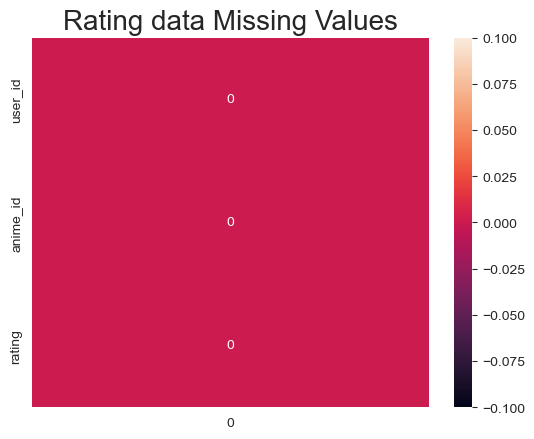

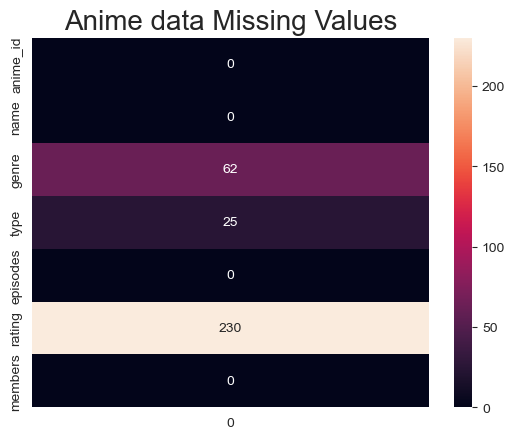

In [3]:
# Check the NaN values of dataset
print("-------------- rating data NaN --------------\n")
print(rating.isnull().sum())
print("-------------- anime data NaN --------------\n")
print(anime.isnull().sum())

plt.title('Rating data Missing Values',fontsize=20)
rating_nan = sns.heatmap(pd.DataFrame(rating.isna().sum()),annot=True,fmt='d')
plt.show()
plt.title('Anime data Missing Values',fontsize=20)
anime_nan = sns.heatmap(pd.DataFrame(anime.isna().sum()),annot=True,fmt='d')
plt.show()


In [4]:
print("-------------- After anime Rating data NaN Drop --------------\n")
anime.dropna(inplace=True)
print(anime.isnull().sum())

-------------- After anime Rating data NaN Drop --------------

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


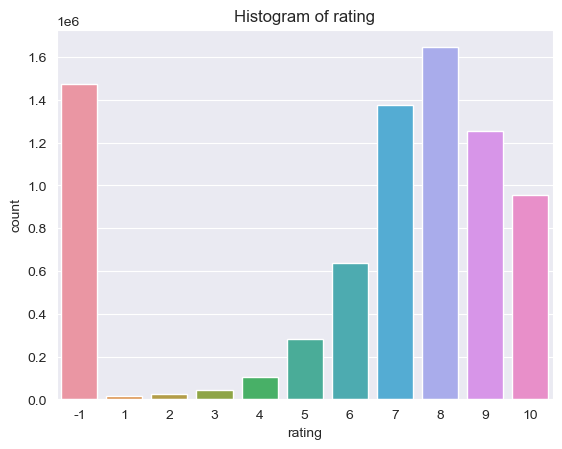

In [5]:
# Determine how the users gave a rating
sns.countplot(x="rating", data=rating)
plt.title("Histogram of rating")
plt.show()

In [6]:
rating_check = rating[rating['rating'] == -1]
rating_check

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813628,73515,2385,-1
7813629,73515,2386,-1
7813631,73515,2490,-1
7813635,73515,2680,-1


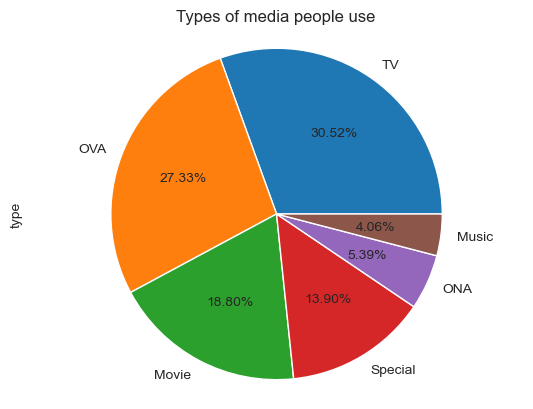

In [7]:
type_check = anime['type'].value_counts()
type_check.plot.pie(autopct='%.2f%%')
plt.title("Types of media people use")
plt.axis('equal')
plt.show()

# Basic Functions

In [8]:
def get_pivot_table(row, column):
    """
    create pivot table
        args:
            row 'list': User-ID or ISBN or Categories
            column 'list': User-ID or ISBN or Categories
        return:
            pTable `DataFrame`: pivot table
    """
    pTable = pd.pivot_table(rating, values='rating', index=row, columns=column)
    return pTable

In [9]:
def get_anime_of_user(userID):
    """
    Get animations id viewed by one user
        args:
            userID : user's id (ex. 1)
        return:
            rating_anime_id : anime_id in rating.csv
    """
    user_index = rating.index[rating['user_id'] == userID].tolist()
    rating_anime_id = []
    for u in range(len(user_index)):
        if rating['rating'][user_index[u]] >= 0:
            rating_anime_id.append(rating['anime_id'][user_index[u]])

    return rating_anime_id

def search_anime_index(recommend_list):
    """
    Get anime_index in anime.csv
        args:
            recommend_list : recommended list for top_num in size
        return:
            anime_index_numbers : anime_index in anime.csv
    """
    anime_index_numbers= []
    for r in range(len(recommend_list)):
        anime_index = anime.index[anime['anime_id'] == recommend_list[r]].tolist()
        anime_index_numbers.append(anime_index[0])

    return anime_index_numbers

# Item-based filtering

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# 사용자가 고른 아이템, 이 아이템하고 비슷한 것 추천해줌
def item_based_CF(userID, n):
    """
    Item-Based Collaborative Filtering
        args:
            userID : user's id (ex. 1)
        return:
            recommend_titles `str 2D List`: The similarities with the recommended titles
    """
    table = get_pivot_table('anime_id', 'user_id')

    table.fillna(0, inplace= True)
    liked_ani = get_anime_of_user(userID)
    recommend2D = []
    cos_sim_table = get_cos_sim_table(table)
    for i in range(len(liked_ani)):
        recommend_list =  recommend_item_based_CF(cos_sim_table, liked_ani, i, 5)
        recommend2D = recommend2D + get_recommend_titles(recommend_list)
    recommendDF = pd.DataFrame(recommend2D, columns=['anime_id','cos_sim'])
    recommendDF = recommendDF.sort_values('cos_sim', ascending = False)[1:(1+n)]
    idx_list=recommendDF['anime_id']
    result=[]
    for i in idx_list:
        result.append(int(anime.loc[anime['anime_id']==i].index.values))
    return result

# # Get animations id viewed by one user
# def get_anime_of_user(userID):
#     '''
#     - parameter:
#         userID : user's id (ex. 1)
#
#     - return
#         rating_anime_id : anime_id in rating.csv
#     '''
#     user_index = rating.index[rating['user_id'] == userID].tolist()
#     rating_anime_id = []
#     for u in range(len(user_index)):
#         if rating['rating'][user_index[u]] >= 0:
#             rating_anime_id.append(rating['anime_id'][user_index[u]])
#
#     return rating_anime_id

def get_cos_sim_table(table):
    """
    Returns a data frame with cosine similarity calculated
        args:
            table `DataFrame`: row = anime_id, col = user_id
        return:
            cos_sim_table `DataFrame`: cosine similarity between anima_id
    """
    cos_sim_table = cosine_similarity(table)
    cos_sim_table = pd.DataFrame(data = cos_sim_table, index= table.index, columns= table.index)
    return cos_sim_table

# cos_sim_table 만들고 유사한 아이템 인덱스 리스트로 반환
# create cos_sim_table and return anime_ides with high similarity
def recommend_item_based_CF(cos_sim_table, liked_ani, liked_ani_idx, n):
    """
    Returns the index of similar items after creating a cosine similarity table.
        args:
            table `DataFrame`: row = anime_id, col = user_id
            anime_id `int`:  anime_id
            n `int`: the number of recommendation
         return:
            recommend_list `DataFrame`: index= anime_id
    """
    # 코사인 유사도 매트릭스에서 liked_ani에 있는 요소는 다 드롭 시킴

    new_cos_sim = cos_sim_table.copy()
    for i in range(len(liked_ani)):
        idx = new_cos_sim[new_cos_sim[liked_ani[liked_ani_idx]] == liked_ani[i]].index     # 메뉴 == 돈까스인 인덱스의 값이 저장됨
        new_cos_sim.drop(idx , inplace=True)

    recommend_list = pd.DataFrame(cos_sim_table.loc[liked_ani[liked_ani_idx]].sort_values(ascending = False)[1:(1+n)])
    return recommend_list

#타이틀 이름 리스트로 반환
def get_recommend_titles(recommend_list):
    """
    Receive anime index and return a list of titles
        args:
            recommend_list`DataFrame`: index= anime_id
        return:
            recommend_id`str 2D list`: anime_id, similarity
    """
    recommend_titles = []
    for i in range(len(recommend_list.index[:])):
        row = []
        row.append(recommend_list.index[:][i])
        row.append(recommend_list.iloc[i, 0])
        recommend_titles.append(row)
    return recommend_titles

# User-based filtering

In [11]:
def user_based(userID, top_num):
    """
    User-based filtering function
        args:
            table `DataFrame`: row = anime_id, col = user_id
            idx `int`:  anime_id
            n 'int': the number of recommendation
         return:
            recommend_list `DataFrame`: index= anime_id
    """
    # Create user-item matrix
    matrix = rating.pivot_table(index='anime_id', columns='user_id', values='rating')

    # Normalize user-item matrix
    matrix.fillna(-2, inplace=True)

    #Get similarity
    matrix_T = matrix.values.T
    user_similarity = np.corrcoef(matrix_T)
    user_similarity = pd.DataFrame(user_similarity)

    # Pick a user ID
    picked_userid = userID

    # Remove picked user ID from the candidate list
    user_similarity.drop(index=picked_userid, inplace=True)

    # Number of similar users
    n = 10

    # User similarity threshold
    user_similarity_threshold = 0.3

    # Get top n similar users
    similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

    # Contents that the target user has watched
    matrix2 = rating.pivot_table(index='user_id', columns='anime_id', values='rating')
    picked_userid_watched = matrix2[matrix2.index == picked_userid].dropna(axis=1, how='all')

    # Contents that similar users watched. Remove anime that none of the similar users have watched
    similar_user_anime = matrix2[matrix2.index.isin(similar_users.index)].dropna(axis=1, how='all')

    # Remove the watched anime from the list
    similar_user_anime.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

    # A dictionary to store item scores
    item_score = {}

    # Loop through items
    for i in similar_user_anime.columns:

        # Get the ratings for anime i
        anime_rating = similar_user_anime[i]

        # Create a variable to store the score and the number of scores
        total = 0
        count = 0

        # Loop through similar users
        for u in similar_users.index:

            # If the anime has rating
            if pd.isna(anime_rating[u]) == False:
                # Score is the sum of user similarity score multiply by the movie rating
                score = similar_users[u] * anime_rating[u]
                # Add the score to the total score for the movie so far
                total += score
                # Add 1 to the count
                count +=1

        # Get the average score for the item
        item_score[i] = total / count

    # Convert dictionary to pandas dataframe
    item_score = pd.DataFrame(item_score.items(), columns=['anime', 'anime_score'])

    # Sort the movies by score
    ranked_item_score = item_score.sort_values(by='anime_score', ascending=False)

    # Select top m movies
    m = 10

    # Average rating for the picked user
    avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

    # Calculate the predicted rating
    ranked_item_score['predicted_rating'] = ranked_item_score['anime_score'] + avg_rating

    # Take a look at the data
    # print(ranked_item_score.head(m))
    result=[]
    for r in range(0,top_num):
        result.append(int(anime.loc[anime['anime_id']==ranked_item_score['anime'][r]].index.values))
    # return list(ranked_item_score[:n].index.values)
    return result


# SVD

In [12]:
def calculate_SVD(transpose_table):
    """
    calculate SVD
        args:
            transpose_table : transpose of pivot table
        return:
            correlation : correlation matrix
    """
    svd = TruncatedSVD(n_components=12)
    svd_matrix = svd.fit_transform(transpose_table)
    correlation = np.corrcoef(svd_matrix)

    return correlation

In [13]:
def get_anime_recommended(table, rating_anime_id, correlation):
    """
    Get recommended anime
    ** If it's the same animation, two lists have the same index
    ex. anime_1 => recommend_list[0] = name of anime_1, score_list[0] = score of anime_1
        args:
            table : pivot table
            rating_anime_id : anime_id in rating.csv
            correlation : correlation matrix
        return:
            recommend_list : recommend list
            score_list : score list
    """
    anime_id = table.columns
    anime_id_list = list(anime_id)
    recommend_list = []
    score_list = []
    for r in range(len(rating_anime_id)):
        anime_index = anime_id_list.index(rating_anime_id[r])
        correlation_coefficient = correlation[anime_index]
        recommend_list.append(list(anime_id[(correlation_coefficient >= 0.9)])[:5])
        score_list.append(list(correlation_coefficient[correlation_coefficient >= 0.9])[:5])

    recommend_list = sum(recommend_list, [])
    score_list = sum(score_list, [])

    return recommend_list, score_list

In [14]:
def get_top_recommend_list(recommend, score, top_num):
    """
    Get Top n recommend list
    ** If it's the same animation, two lists have the same index
    ex. anime_1 => recommend[0] = name of anime_1, score[0] = score of anime_1
        args:
            recommend : recommend list
            score : score list
            top_num = the number of recommendation
        return:
            checked_recommend_list : recommended list for top_num in size
    """
    l = zip(score,recommend)
    pairs = sorted(l, reverse=True)
    score_recommend_tuples = zip(*pairs)

    score_list, recommend_list = [list(t) for t in score_recommend_tuples]

    checked_recommend_list = []
    for r in recommend_list:
        if r not in checked_recommend_list:
            checked_recommend_list.append(r)

    return checked_recommend_list[:top_num]

In [15]:
def get_anime_info(anime_index_number):
    """
    # Get anime info ( Anime name, Genre, Average Rating )
        args:
            anime_index_numbers : anime_index in anime.csv
        return:
            name : anime name
            genre : anime's Genre
            avg_rating : anime's average rating
    """
    name = anime['name'][anime_index_number]
    genre = anime['genre'][anime_index_number]
    avg_rating = str(anime['rating'][anime_index_number])

    return name, genre, avg_rating

In [16]:
def print_anime_name(name, genre, avg_rating):
    """
    Get print Result
        args:
            name : anime name
            genre : anime's Genre
            avg_rating : anime's average rating
        return:
            None (print result)
    """
    print("Anime Name : " + name )
    print("- Genre : " + genre)
    print("- Average Rating : " + avg_rating)

In [17]:
def svd_recommend_system(user_id, top_num):
    """
    SVD main function
        args:
            user_id = user's id
            top_num = the number of recommendation
        return:
            anime_index_numbers : anime_index in anime.csv
    """
    pTable = get_pivot_table('user_id', 'anime_id')
    pTable.fillna(0, inplace=True)
    pTable_T = pTable.values.T

    correlation = calculate_SVD(pTable_T)
    rating_anime_id = get_anime_of_user(user_id)
    recommend_id_list, similarity_score_list = get_anime_recommended(pTable, rating_anime_id, correlation)
    top_recommend_list = get_top_recommend_list(recommend_id_list, similarity_score_list, top_num)
    anime_index_numbers = search_anime_index(top_recommend_list)

    return anime_index_numbers

# Content-based-filtering

In [18]:
def calculate_scores(anime_id, top_num=5):
    """
    Calculate similarity based on genre values of anime
        args:
            anime_id : anime_id to calculate similarity
            top_num : the number of recommendation
        return:
            similarity_scores : Dataframe with index of anime_id and value of similarity score
    """
    # vectorize genre value with TfidfVectorizer
    tfidf=TfidfVectorizer(stop_words='english')
    anime['genre']=anime['genre'].fillna('')
    tfidf_matrix=tfidf.fit_transform(anime['genre'])
    cosine_sim=cosine_similarity(tfidf_matrix, tfidf_matrix)

    # get index with anime id
    indices = pd.Series(anime.index, index=anime['anime_id'])
    indices = indices[~indices.index.duplicated(keep='last')]

    anime_index = indices[anime_id]
    similarity_scores = pd.DataFrame(cosine_sim[anime_index], columns=['score'])
    anime_indices = similarity_scores.sort_values('score', ascending=False)[1:(1+top_num)].index

    return pd.DataFrame(similarity_scores.iloc[anime_indices])

In [19]:
def watched_anime(userID):
    """
    Get anime id that the user have rated more than average
        args:
            userID: user id to get watched anime id list
        return:
            result: anime_id list the user like
    """
    result=[]
    animes=rating[rating['user_id']==userID]
    for i in animes.index:
        if animes['rating'][i]>=round(mean(animes['rating']),2):
            result.append(animes['anime_id'][i])
    return result

In [20]:
def content_based_filtering(user_id, n):
    """
    Content based filtering main function
        args:
            user_id: user to get recommendation,
            n: the number of anime to get recommendation
        return:
            result: recommended anime_id list
    """
    # get anime_id
    anime_id=watched_anime(user_id)
    scores=pd.DataFrame()
    for idx in anime_id:
        similarity=calculate_scores(idx, 5)
        scores=pd.concat([scores,similarity['score']])
    scores.columns=['score']
    scores=scores.sort_values(by='score', ascending=False)
    # remove the anime that the user already watched
    watched = get_anime_of_user(user_id)
    for s in scores.index:
        if s in anime_id:
            scores.drop(s)
    return list(scores[:n].index.values)

# Output Image Results

In [21]:
def setting():
    """
    Get image settings
        args:
            None
        return:
            driver : Web Crawling Driver
    """
    options = webdriver.ChromeOptions()
    options.headless = True
    options.add_argument("window-size=1920x1080")

    driver_setting = webdriver.Chrome(ChromeDriverManager().install(), options=options)  #options=options

    return driver_setting

In [22]:
def search_img(driver_setting, name):
    """
    Search Image in Google
        args:
            driver : Web Crawling Driver
            name : search word
        return:
            imgUrl : image URL of search word
    """
    driver_setting.get("https://www.google.co.kr/imghp?hl=ko&tab=wi&ogbl")
    time.sleep(1)

    elem = driver_setting.find_element_by_name("q")
    elem.send_keys(name)

    elem.send_keys(Keys.RETURN)

    #이미지 찾고 다운받기
    time.sleep(1)
    images = driver_setting.find_elements_by_css_selector(".rg_i.Q4LuWd")
    time.sleep(1)
    images[0].click()
    time.sleep(1)

    imgUrl = driver_setting.find_element_by_css_selector(".n3VNCb").get_attribute("src")
    time.sleep(1)
    return imgUrl

def get_img(imgUrl):
    """
    Get image from url
        args:
            imgUrl : image URL of search word
        return:
            request_get_img : Image URL open format
    """
    # request.get 요청
    time.sleep(1)
    res = requests.get(imgUrl)
    time.sleep(1)

    #Img open
    request_get_img = Image.open(BytesIO(res.content))

    return request_get_img

In [23]:
def floating_img(img_list, anime_index_numbers):
    """
    Print result with Images
        args:
            img_list : list of image URLs
            anime_index_numbers : anime_index in anime.csv
        return:
            None (print result with Images)
    """
    p = 5
    num = len(img_list)
    plt.figure(figsize=(100, 70))
    for n in range(5):
        name, genre, avg_rating = get_anime_info(anime_index_numbers[n])
        title = name + "\n[ " + genre + " ]\nAverage Rating : " + avg_rating

        plt.subplot(1, 5,n+1)
        plt.imshow(img_list[n])
        plt.title(title, pad=25, fontsize=30)

        plt.axis('off')
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

# Total Function

In [27]:
def recommend_system(user_id, mode, n):
    """
    Whole function to run recommendation system
        args:
            mode : determines recommendation system
                1: Item_based
                2: User_based
                3: SVD
                else: Content-based filtering
            user_id : user id to get recommendation
            n: the number of anime to get recommendation
        return:
            result: list of recommended anime index of anime.csv
    """
    recommend_idx_list=[]
    if mode=="item":
        recommend_idx_list = item_based_CF(user_id, n)
    elif mode=="user":
        recommend_idx_list=user_based(user_id, n)
    elif mode=="svd":
        recommend_idx_list=svd_recommend_system(user_id, n)
    elif mode == "content":
        recommend_idx_list=content_based_filtering(user_id, n)
    else:
        print("::| ERROR: Undefined Mode |::")
        return 0

    # print result with images
    # driver setting
    driver = setting()
    # print Images
    image_list = []
    for i in range(len(recommend_idx_list)):
        img_url = search_img(driver, anime['name'][recommend_idx_list[i]])
        img = get_img(img_url)
        image_list.append(img)
    floating_img(image_list, recommend_idx_list)
    plt.show()

In [25]:
USER_ID = 8
MODES = ['item', 'user', 'svd', 'content']
NUMBER = 5

In [ ]:
for MODE in MODES:
    recommend_system(USER_ID, MODE, NUMBER)